In [1]:
from collections import defaultdict
from dataclasses import dataclass
from functools import wraps
import random
from time import perf_counter_ns

import torch
from evo import Evo, generate
from stripedhyena.sample import sample

from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import OneHotEncoder

# Setup

In [2]:
# run on GPU if available, otherwise panic
if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available, just don't do it")

device = torch.device("cuda:0")

In [3]:
# download the model
evo_model = Evo("evo-1.5-8k-base")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# extract tokenizer and model
tokenizer = evo_model.tokenizer
model = evo_model.model.to(device)

# Utils

In [5]:
def get_internal_acgt_probs(seq):
    """Get per-position nucleotide probabilities within a sequence. They go from position 1 to k+1."""
    tokens = torch.tensor(tokenizer.tokenize(seq), dtype=torch.int).unsqueeze(0).to(device)
    with torch.inference_mode():
        logits, _ = model(tokens)
    acgt_logits = logits[0,:,(65,67,71,84)]
    acgt_probs = torch.softmax(acgt_logits, dim=-1)
    return acgt_probs

In [12]:
def periodic_array(k, period):
    """Create a periodic numbering of a given length."""
    reps = k // period + 1
    return np.tile(range(1,period+1), reps)[:k]

In [11]:
periodic_array(10,3)

array([1, 2, 3, 1, 2, 3, 1, 2, 3, 1])

In [18]:
def periodicity_from_fasta(path, k=1000, period=3):
    with open(path) as f:
        seqs = SeqIO.parse(f, "fasta")
        seq = next(seqs)
    probs = get_internal_acgt_probs(str(seq.seq)[:k])
    conf = probs.max(dim=1).values.to(torch.float32).to("cpu").numpy()
    pos = periodic_array(k, period)
    df_full = pd.DataFrame({"conf": conf, "pos": pos})
    return df_full.groupby("pos").mean(), df_full["conf"].mean()

In [22]:
p_cds, mean_cds = periodicity_from_fasta("seqs/cds_1.fa")
print(mean_cds)
p_cds

0.501041


,conf
pos,
1,0.477206
2,0.599803
3,0.426186


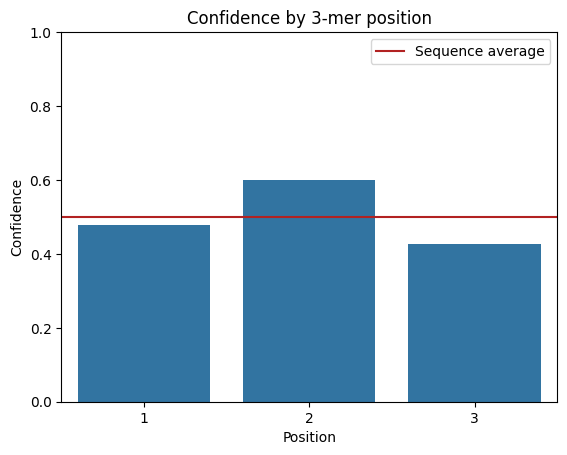

In [37]:
ax = sns.barplot(data = p_cds, x = "pos", y = "conf")
ax.set_ylim(0,1)
ax.axhline(y = mean_intergenic, color="firebrick", label="Sequence average")
ax.set(title="Confidence by 3-mer position", xlabel="Position", ylabel="Confidence")
ax.legend()

In [42]:
p_intron, mean_intron = periodicity_from_fasta("seqs/intron_1.fa")
print(mean_intron)
p_intron

0.4045215


,conf
pos,
1,0.391847
2,0.413400
3,0.408356


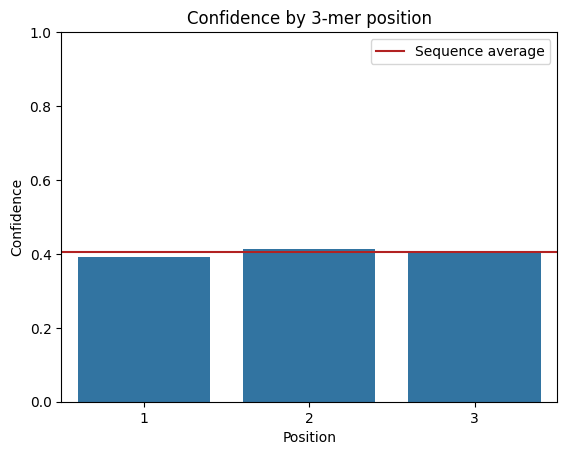

In [43]:
ax = sns.barplot(data = p_intron, x = "pos", y = "conf")
ax.set_ylim(0,1)
ax.axhline(y = mean_intron, color="firebrick", label="Sequence average")
ax.set(title="Confidence by 3-mer position", xlabel="Position", ylabel="Confidence")
ax.legend()

In [24]:
p_intergenic, mean_intergenic = periodicity_from_fasta("seqs/intergenic_1.fa")
print(mean_intergenic)
p_intergenic

0.5949063


,conf
pos,
1,0.595247
2,0.596964
3,0.592507


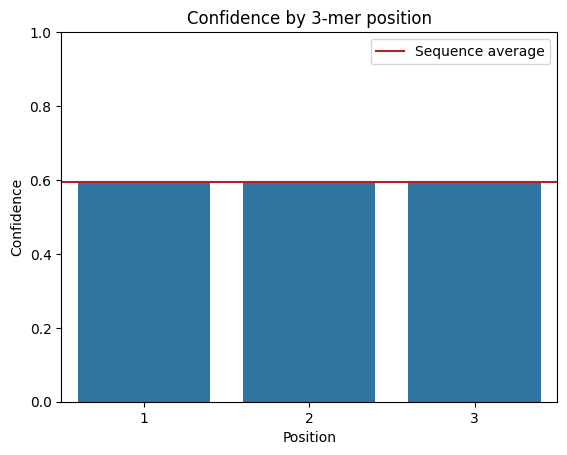

In [39]:
ax = sns.barplot(data = p_intergenic, x = "pos", y = "conf")
ax.set_ylim(0,1)
ax.axhline(y = mean_intergenic, color="firebrick", label="Sequence average")
ax.set(title="Confidence by 3-mer position", xlabel="Position", ylabel="Confidence")
ax.legend()

In [25]:
p_lnc, mean_lnc = periodicity_from_fasta("seqs/lnc_1.fa")
print(mean_lnc)
p_lnc

0.3755625


,conf
pos,
1,0.373415
2,0.375821
3,0.377458


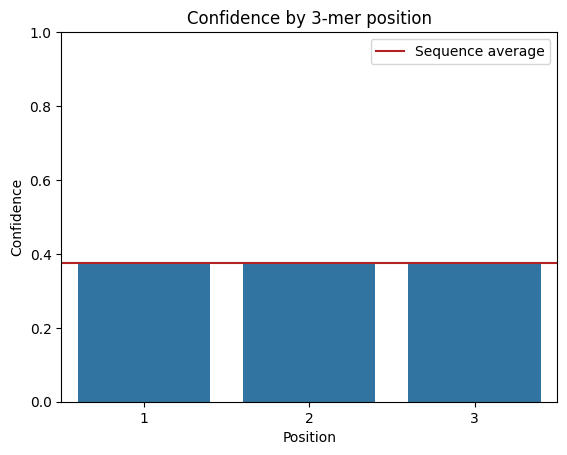

In [40]:
ax = sns.barplot(data = p_lnc, x = "pos", y = "conf")
ax.set_ylim(0,1)
ax.axhline(y = mean_lnc, color="firebrick", label="Sequence average")
ax.set(title="Confidence by 3-mer position", xlabel="Position", ylabel="Confidence")
ax.legend()

In [44]:
p_cds_4, mean_cds_4 = periodicity_from_fasta("seqs/cds_1.fa", period=4)
print(mean_cds_4)
p_cds_4

0.501041


,conf
pos,
1,0.506789
2,0.500984
3,0.500820
4,0.495570


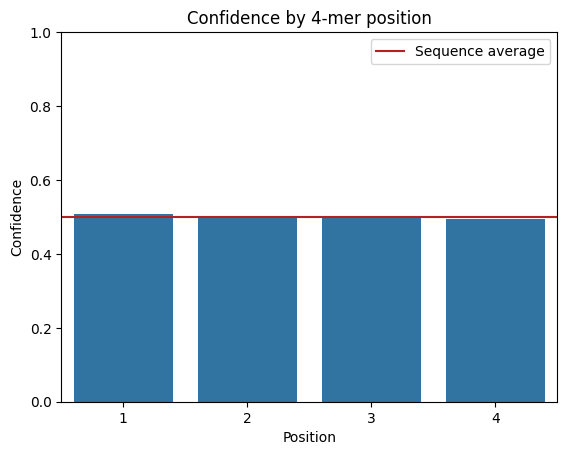

In [47]:
ax = sns.barplot(data = p_cds_4, x = "pos", y = "conf")
ax.set_ylim(0,1)
ax.axhline(y = mean_cds_4, color="firebrick", label="Sequence average")
ax.set(title="Confidence by 4-mer position", xlabel="Position", ylabel="Confidence")
ax.legend()

In [48]:
p_intron_4, mean_intron_4 = periodicity_from_fasta("seqs/intron_1.fa", period=4)
print(mean_intron_4)
p_intron_4

0.4045215


,conf
pos,
1,0.404633
2,0.406711
3,0.403734
4,0.403008


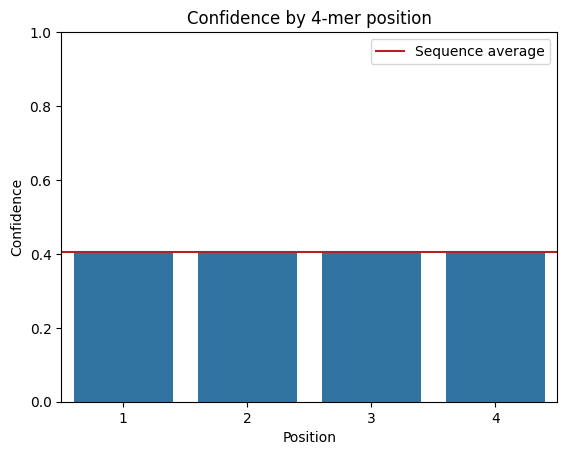

In [51]:
ax = sns.barplot(data = p_intron_4, x = "pos", y = "conf")
ax.set_ylim(0,1)
ax.axhline(y = mean_intron_4, color="firebrick", label="Sequence average")
ax.set(title="Confidence by 4-mer position", xlabel="Position", ylabel="Confidence")
ax.legend()

In [49]:
p_intergenic_4, mean_intergenic_4 = periodicity_from_fasta("seqs/intergenic_1.fa", period=4)
print(mean_intergenic_4)
p_intergenic_4

0.5949063


,conf
pos,
1,0.590773
2,0.594117
3,0.602484
4,0.592250


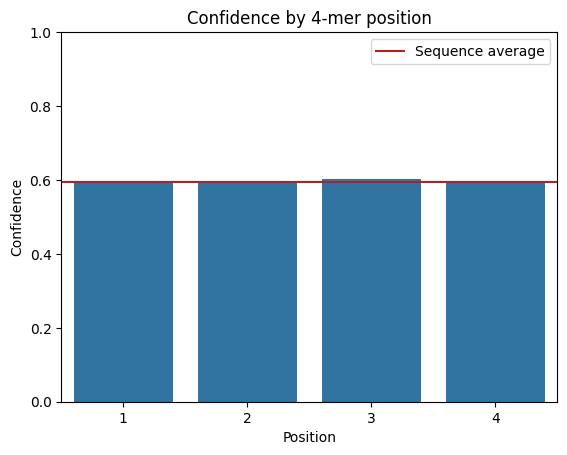

In [52]:
ax = sns.barplot(data = p_intergenic_4, x = "pos", y = "conf")
ax.set_ylim(0,1)
ax.axhline(y = mean_intergenic_4, color="firebrick", label="Sequence average")
ax.set(title="Confidence by 4-mer position", xlabel="Position", ylabel="Confidence")
ax.legend()

In [50]:
p_lnc_4, mean_lnc_4 = periodicity_from_fasta("seqs/lnc_1.fa", period=4)
print(mean_lnc_4)
p_lnc_4

0.3755625


,conf
pos,
1,0.379305
2,0.374109
3,0.373570
4,0.375266


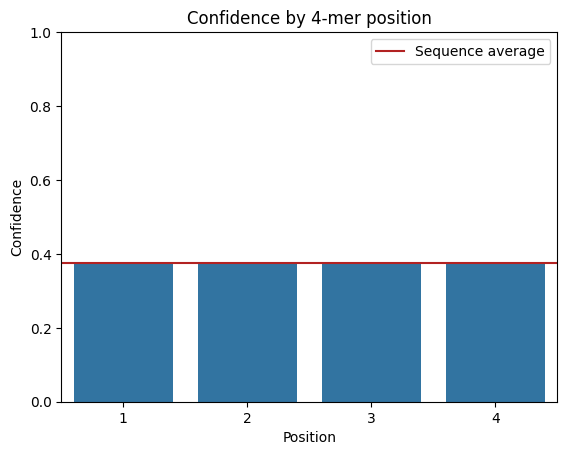

In [53]:
ax = sns.barplot(data = p_lnc_4, x = "pos", y = "conf")
ax.set_ylim(0,1)
ax.axhline(y = mean_lnc_4, color="firebrick", label="Sequence average")
ax.set(title="Confidence by 4-mer position", xlabel="Position", ylabel="Confidence")
ax.legend()